# Data Description

# Import Tools

In [1]:
#import EDA tools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler

#import modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#import evaluation tools
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

#ignore warnings
from warnings import filterwarnings
filterwarnings(action='ignore')

# Load Dataset

In [2]:
#load train and test dataframe
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

* As you see, some of our features are object. Let's convert them to suitable Dtype.

In [4]:
#Convert objects to categories
for label,content in train_df.items():
    if pd.api.types.is_string_dtype(content):
        train_df[label]=content.astype("category").cat.as_ordered()

# Handling Missing values

In [5]:
#Turn categorical values into numbers and fill missing
# +1 is done to convert -1 to 0. pd.Categories fills empty vales with Code -1. As we do not want any negative data in our 
#evaluation we are going to add 1 to it so that it becomes 0
for label, content in train_df.items():
    if not pd.api.types.is_numeric_dtype(content):
        train_df[label] =pd.Categorical(content).codes +1

In [6]:
train_df.isna().sum().sort_values(ascending=False)[:20]

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
Id                0
KitchenAbvGr      0
GarageType        0
FireplaceQu       0
Fireplaces        0
Functional        0
TotRmsAbvGrd      0
KitchenQual       0
BedroomAbvGr      0
GarageCars        0
HalfBath          0
FullBath          0
BsmtHalfBath      0
BsmtFullBath      0
GrLivArea         0
LowQualFinSF      0
2ndFlrSF          0
dtype: int64

In [7]:
#Filling missing values
train_df["LotFrontage"].fillna(method="bfill", inplace=True)
train_df["GarageYrBlt"].fillna(method="bfill", inplace=True)
train_df["MasVnrArea"].fillna(method="bfill", inplace=True)

In [8]:
train_df.isna().sum().sort_values(ascending=False)[:20]

Id              0
CentralAir      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
1stFlrSF        0
GarageFinish    0
dtype: int64

# Feature Selection

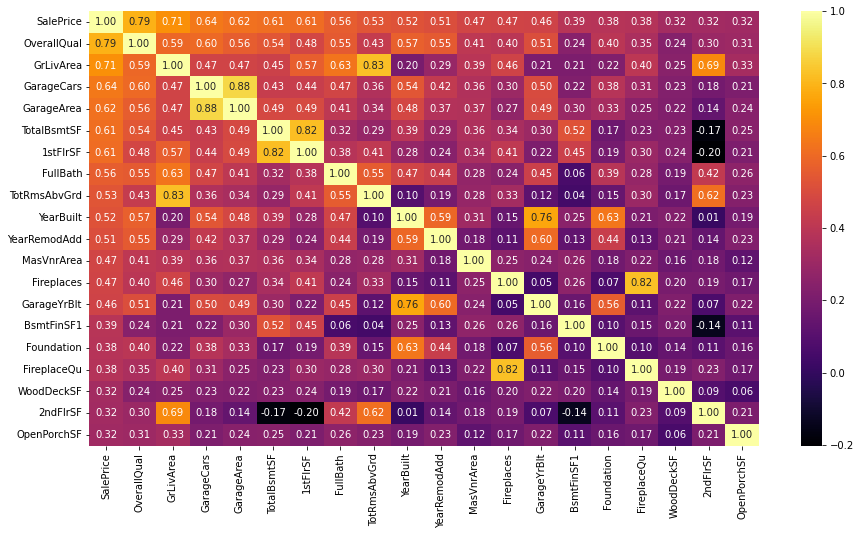

In [9]:
#Correlation matrix
df_corr = train_df.corr()
cols = df_corr.nlargest(20, 'SalePrice')['SalePrice'].index

fig = plt.subplots(figsize=(15,8))

sns.heatmap(train_df[cols].corr(),
            annot=True,
            fmt="0.2f",
            cmap="inferno");

* According to correlation matrix, these columns are highly correlated with SalePrice!
* Also we can get some features have the same effect on making SalePrice.
* As you know, decreasing dimensions may have good effect on our score, so we are going to drop one per each pair of same features.
###### Pairs : GarageCars and GarageArea, TotalBsmtSF and 1stFlrSF, YearBuilt and YearRemodAdd, Fireplaces and MasVnrArea

In [10]:
#drop features with the same effect on SalePrice
df = train_df[cols].drop(['GarageCars', 'TotalBsmtSF','YearBuilt', 'MasVnrArea'], axis=1)
df['Id'] = train_df['Id']
df

,SalePrice,OverallQual,GrLivArea,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearRemodAdd,Fireplaces,GarageYrBlt,BsmtFinSF1,Foundation,FireplaceQu,WoodDeckSF,2ndFlrSF,OpenPorchSF,Id
0,208500,7,1710,548,856,2,8,2003,0,2003.0,706,3,0,0,854,61,1
1,181500,6,1262,460,1262,2,6,1976,1,1976.0,978,2,5,298,0,0,2
2,223500,7,1786,608,920,2,6,2002,1,2001.0,486,3,5,0,866,42,3
3,140000,7,1717,642,961,1,7,1970,1,1998.0,216,1,3,0,756,35,4
4,250000,8,2198,836,1145,2,9,2000,1,2000.0,655,3,5,192,1053,84,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,460,953,2,7,2000,1,1999.0,0,3,5,0,694,40,1456
1456,210000,6,2073,500,2073,2,7,1988,2,1978.0,790,2,5,349,0,0,1457
1457,266500,7,2340,252,1188,2,9,2006,2,1941.0,275,5,3,0,1152,60,1458
1458,142125,5,1078,240,1078,1,5,1996,0,1950.0,49,2,0,366,0,0,1459


# Detecing Outliers

In [11]:
df.describe()

,SalePrice,OverallQual,GrLivArea,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearRemodAdd,Fireplaces,GarageYrBlt,BsmtFinSF1,Foundation,FireplaceQu,WoodDeckSF,2ndFlrSF,OpenPorchSF,Id
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,6.099315,1515.463699,472.980137,1162.626712,1.565068,6.517808,1984.865753,0.613014,1978.217123,443.639726,2.396575,1.969178,94.244521,346.992466,46.660274,730.500000
std,79442.502883,1.382997,525.480383,213.804841,386.587738,0.550916,1.625393,20.645407,0.644666,24.716517,456.098091,0.722394,2.037956,125.338794,436.528436,66.256028,421.610009
min,34900.000000,1.000000,334.000000,0.000000,334.000000,0.000000,2.000000,1950.000000,0.000000,1900.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,129975.000000,5.000000,1129.500000,334.500000,882.000000,1.000000,5.000000,1967.000000,0.000000,1961.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,365.750000
50%,163000.000000,6.000000,1464.000000,480.000000,1087.000000,2.000000,6.000000,1994.000000,1.000000,1979.000000,383.500000,2.000000,2.000000,0.000000,0.000000,25.000000,730.500000
75%,214000.000000,7.000000,1776.750000,576.000000,1391.250000,2.000000,7.000000,2004.000000,1.000000,2002.000000,712.250000,3.000000,3.000000,168.000000,728.000000,68.000000,1095.250000
max,755000.000000,10.000000,5642.000000,1418.000000,4692.000000,3.000000,14.000000,2010.000000,3.000000,2010.000000,5644.000000,6.000000,5.000000,857.000000,2065.000000,547.000000,1460.000000


* According to our dataframe describe, mean of SalePrice is about 180,000 but max of SalePrice is 755,000!!!!

### Visiualizing

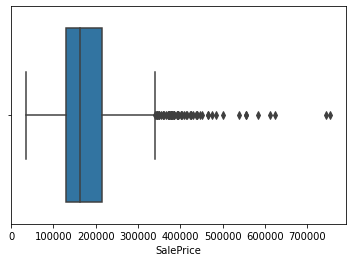

In [12]:
sns.boxplot(x=df['SalePrice']);

In [13]:
df["SalePrice"].sort_values(ascending=False)

691     755000
1182    745000
1169    625000
898     611657
803     582933
         ...  
30       40000
533      39300
968      37900
916      35311
495      34900
Name: SalePrice, Length: 1460, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SalePrice     1460 non-null   int64  
 1   OverallQual   1460 non-null   int64  
 2   GrLivArea     1460 non-null   int64  
 3   GarageArea    1460 non-null   int64  
 4   1stFlrSF      1460 non-null   int64  
 5   FullBath      1460 non-null   int64  
 6   TotRmsAbvGrd  1460 non-null   int64  
 7   YearRemodAdd  1460 non-null   int64  
 8   Fireplaces    1460 non-null   int64  
 9   GarageYrBlt   1460 non-null   float64
 10  BsmtFinSF1    1460 non-null   int64  
 11  Foundation    1460 non-null   int8   
 12  FireplaceQu   1460 non-null   int8   
 13  WoodDeckSF    1460 non-null   int64  
 14  2ndFlrSF      1460 non-null   int64  
 15  OpenPorchSF   1460 non-null   int64  
 16  Id            1460 non-null   int64  
dtypes: float64(1), int64(14), int8(2)
memory usage: 174.1 KB


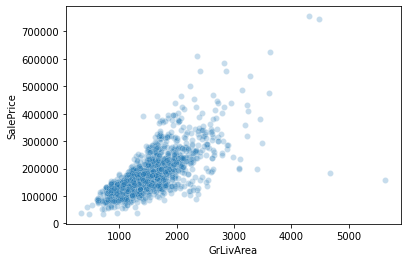

In [15]:
    sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], alpha=0.25)
    plt.show()

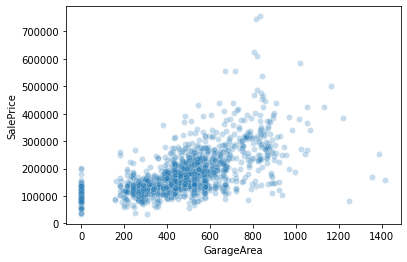

In [16]:
sns.scatterplot(x=df['GarageArea'], y=df['SalePrice'], alpha=0.25)
plt.show()

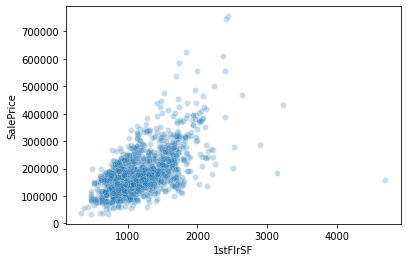

In [17]:
sns.scatterplot(x=df['1stFlrSF'], y=df['SalePrice'], alpha=0.25)
plt.show()

In [18]:
#Detecting outliers
for i in df.select_dtypes(include=['float64','int64']).columns:
    max_threshold=df[i].quantile(0.95)
    min_threshold=df[i].quantile(0.05)
    df_no_outlier=df[(df[i] < max_threshold) & (df[i] > min_threshold)].shape
    print(" outlier in ",i,"is" ,int(((df.shape[0]-df_no_outlier[0])/df.shape[0])*100),"%")

 outlier in  SalePrice is 10 %
 outlier in  OverallQual is 25 %
 outlier in  GrLivArea is 10 %
 outlier in  GarageArea is 10 %
 outlier in  1stFlrSF is 10 %
 outlier in  FullBath is 100 %
 outlier in  TotRmsAbvGrd is 13 %
 outlier in  YearRemodAdd is 22 %
 outlier in  Fireplaces is 55 %
 outlier in  GarageYrBlt is 12 %
 outlier in  BsmtFinSF1 is 37 %
 outlier in  WoodDeckSF is 57 %
 outlier in  2ndFlrSF is 61 %
 outlier in  OpenPorchSF is 49 %
 outlier in  Id is 10 %


In [19]:
#remove outliers from columns having nearly 10% outlier
max_threshold_SalePrice=df["SalePrice"].quantile(0.95)
min_threshold_SalePrice=df["SalePrice"].quantile(0.05)
max_threshold_GrLivArea=df["GrLivArea"].quantile(0.95)
min_threshold_GrLivArea=df["GrLivArea"].quantile(0.05)
max_threshold_GarageArea=df["GarageArea"].quantile(0.95)
min_threshold_GarageArea=df["GarageArea"].quantile(0.05)
max_threshold_1stFlrSF=df["1stFlrSF"].quantile(0.95)
min_threshold_1stFlrSF=df["1stFlrSF"].quantile(0.05)
max_threshold_TotRmsAbvGrd=df["TotRmsAbvGrd"].quantile(0.95)
min_threshold_TotRmsAbvGrd=df["TotRmsAbvGrd"].quantile(0.05)
max_threshold_GarageYrBlt=df["GarageYrBlt"].quantile(0.95)
min_threshold_GarageYrBlt=df["GarageYrBlt"].quantile(0.05)
max_threshold_Id=df["Id"].quantile(0.95)
min_threshold_Id=df["Id"].quantile(0.05)


df_no_outlier=df[(df["SalePrice"] < max_threshold_SalePrice) & (df["SalePrice"] > min_threshold_SalePrice) & (df["GrLivArea"] < max_threshold_GrLivArea) & (df["GrLivArea"] > min_threshold_GrLivArea) &  (df["GarageArea"] < max_threshold_GarageArea) & (df["GarageArea"] > min_threshold_GarageArea) &  (df["1stFlrSF"] < max_threshold_1stFlrSF) & (df["1stFlrSF"] > min_threshold_1stFlrSF) &  (df["TotRmsAbvGrd"] < max_threshold_TotRmsAbvGrd) & (df["TotRmsAbvGrd"] > min_threshold_TotRmsAbvGrd) &  (df["GarageYrBlt"] < max_threshold_GarageYrBlt) & (df["GarageYrBlt"] > min_threshold_GarageYrBlt) &  (df["Id"] < max_threshold_Id) & (df["Id"] > min_threshold_Id)]

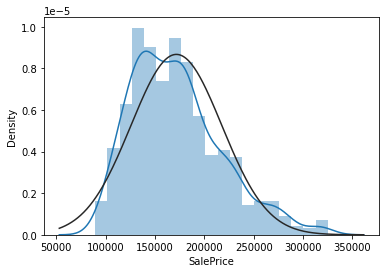

In [20]:
#checking prices distribution
sns.distplot(df_no_outlier['SalePrice'], fit=stats.norm);

* Nice! No need to normalize data!!!

# Preparing Data to Train Model

In [21]:
#Split data
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [22]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)